<a href="https://colab.research.google.com/github/b0shy/Stock-Price-Prediction/blob/main/Stock_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
FIRST_NAME = "Bashar"
LAST_NAME = "Shabani"
STUDENT_ID = "801133494"

# Stock Price Prediction Using Recurrent Neural Networks (RNN)

This notebook implements a stock price prediction model using a Recurrent Neural Network (RNN) with two layers

## Project Overview
Stock prices are influenced by a variety of factors, and predicting future prices requires models capable of capturing sequential patterns over time. In this project, we will:
- Load and preprocess historical stock data from Yahoo Finance.
- Experiment with different time window sizes (5 and 10 days) for sequence-based prediction.
- Construct and train a two-layer RNN model with dropout layers to reduce overfitting.
- Evaluate the model's performance using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE).
- Visualize the predicted prices against actual prices and assess the model's convergence.
- Generate a next-day stock price prediction using the trained model.

Each cell in this notebook corresponds to a specific stage in the modeling process, from data loading and preprocessing to model evaluation and visualization.

## Libraries Used
- `numpy` and `pandas` for data manipulation
- `yfinance` for downloading stock data
- `tensorflow.keras` for building and training the RNN model
- `sklearn` for data scaling and performance metrics
- `matplotlib` for data visualization

Let's get started!


# Initial Setup: Load Libraries and Download Historical Stock Data
This cell sets up the necessary libraries, initializes the stock symbol and date range, and loads historical stock data using Yahoo Finance.

In [11]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load historical stock price data from Yahoo Finance
company = 'AAPL'  # Specify the stock ticker symbol
start = dt.datetime(2012, 1, 1)
end = dt.datetime.now()

# Download the stock data within the specified date range
data = yf.download(company, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


# Data Preprocessing: Normalize Data and Create Sequence Generation Function
This cell preprocesses the data by scaling the 'Close' prices for use in the model and defines a function to create input sequences of past values for time series forecasting.

In [12]:
# Scale the 'Close' price data to values between 0 and 1 for normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Function to create sequences for time series forecasting based on timesteps
def create_sequences(data, timesteps):
    x, y = [], []
    for i in range(timesteps, len(data)):
        x.append(data[i - timesteps:i, 0])  # Create sequences of length `timesteps`
        y.append(data[i, 0])  # Target value is the price after the sequence
    return np.array(x), np.array(y)

# Model Construction: Build and Train Two-Layer RNN Model with Dropout Layers
This cell constructs the RNN model architecture, with two SimpleRNN layers and dropout layers to reduce overfitting. It also trains the model on the prepared sequences.

In [13]:
# Initialize timesteps list and results dictionary
timesteps_list = [5, 10]
results = {}         # To store performance metrics
histories = {}       # To store training history
predictions = {}     # To store predictions for plotting
next_day_predictions = {}  # To store next-day predictions

# Loop over each timestep configuration to build, train, and evaluate models
for timesteps in timesteps_list:
    print(f"\nProcessing for timesteps={timesteps}...\n")

    # Prepare training sequences with the specified timestep
    x_train, y_train = create_sequences(scaled_data, timesteps)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))  # Reshape for RNN input

    # Build the RNN model with two layers as specified
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(timesteps, 1)))  # First RNN layer
    model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
    model.add(SimpleRNN(units=100))  # Second RNN layer with more units
    model.add(Dropout(0.2))  # Dropout layer
    model.add(Dense(units=1))  # Output layer for predicting the next closing price

    model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model with MSE loss

    # Train the model and save the training history for loss visualization
    history = model.fit(x_train, y_train, epochs=50, batch_size=64, verbose=1, validation_split=0.2)

    # Save the history for later visualization
    histories[timesteps] = history

    # Prepare test data starting from 2021
    test_start = dt.datetime(2021, 1, 1)
    test_end = dt.datetime.now()
    test_data = yf.download(company, start=test_start, end=test_end)
    actual_prices = test_data['Close'].values  # Actual closing prices for comparison

    # Prepare model inputs for test data
    total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
    model_inputs = total_dataset[len(total_dataset) - len(test_data) - timesteps:].values
    model_inputs = model_inputs.reshape(-1, 1)  # Reshape for scaling
    model_inputs = scaler.transform(model_inputs)  # Scale the combined dataset

    # Create test sequences for prediction based on the `timesteps`
    x_test, y_test = create_sequences(model_inputs, timesteps)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  # Reshape for RNN input

    # Make predictions
    predicted_prices = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)  # Transform predictions back to original scale

    # Save predictions for later plotting
    predictions[timesteps] = predicted_prices

    # Calculate performance metrics: MSE, RMSE, and MAE
    mse = mean_squared_error(actual_prices[-len(predicted_prices):], predicted_prices)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_prices[-len(predicted_prices):], predicted_prices)
    results[timesteps] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae}  # Store metrics for comparison

    # Predict the next day price based on the latest available data
    real_data = [model_inputs[-timesteps:, 0]]  # Get the last 'timesteps' data points
    real_data = np.array(real_data)
    real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))  # Reshape for model input

    prediction = model.predict(real_data)  # Predict the next day price
    prediction = scaler.inverse_transform(prediction)  # Transform prediction back to original scale
    next_day_predictions[timesteps] = prediction[0][0]

    print(f"Next Day Prediction with timesteps={timesteps}: {prediction[0][0]}")



Processing for timesteps=5...

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0419 - val_loss: 0.0118
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - val_loss: 0.0012
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - val_loss: 9.6606e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 7.2795e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 8.3240e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 8.0218e-04
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.4596e-04 - val_loss: 7.5194e-04
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010 - val_loss: 6.1994e-04
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - los

[*********************100%***********************]  1 of 1 completed


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Next Day Prediction with timesteps=5: 224.4986114501953

Processing for timesteps=10...

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0483 - val_loss: 0.0046
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066 - val_loss: 0.0042
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023 - val_loss: 0.0043
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014 - val_loss: 6.7760e-04
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - v

[*********************100%***********************]  1 of 1 completed


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Next Day Prediction with timesteps=10: 227.6561279296875


# Performance Evaluation: Calculate Metrics and Visualize Predictions
This cell calculates the MSE, RMSE, and MAE for model evaluation, then plots both the actual vs. predicted prices and the training/validation loss to visualize model accuracy and convergence.

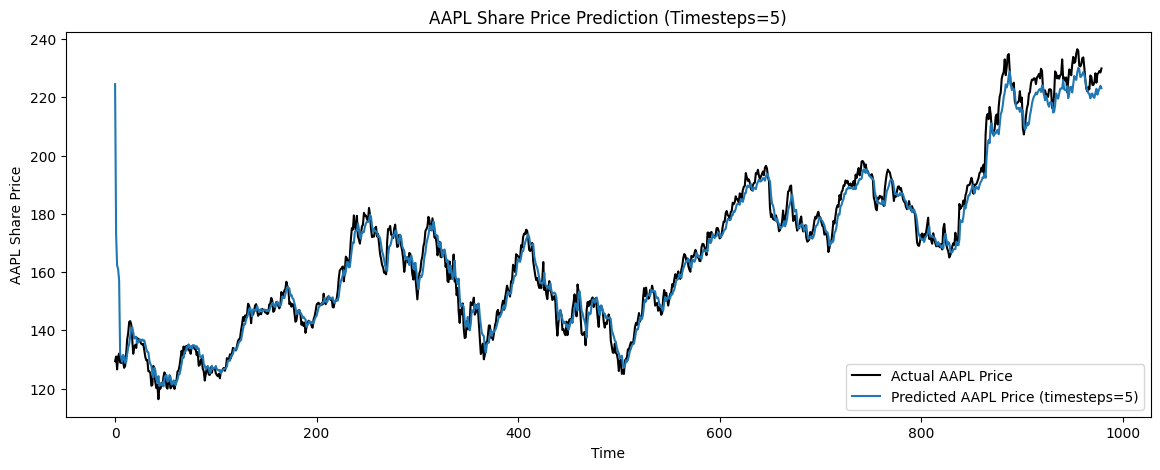

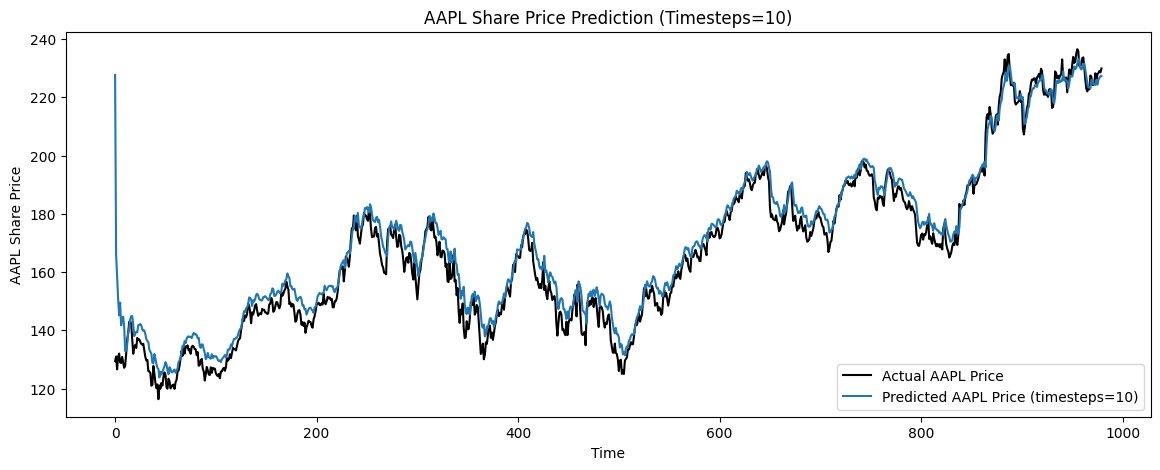

In [14]:
# Plot actual vs. predicted prices for each timestep configuration
for timesteps in timesteps_list:
    predicted_prices = predictions[timesteps]
    plt.figure(figsize=(14, 5))
    plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
    plt.plot(range(len(actual_prices) - len(predicted_prices), len(actual_prices)), predicted_prices,
             label=f"Predicted {company} Price (timesteps={timesteps})")
    plt.title(f"{company} Share Price Prediction (Timesteps={timesteps})")
    plt.xlabel('Time')
    plt.ylabel(f'{company} Share Price')
    plt.legend()
    plt.show()


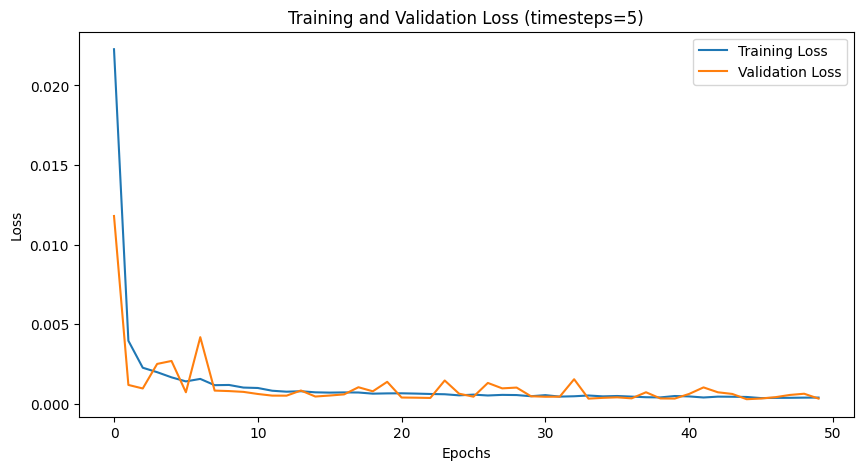

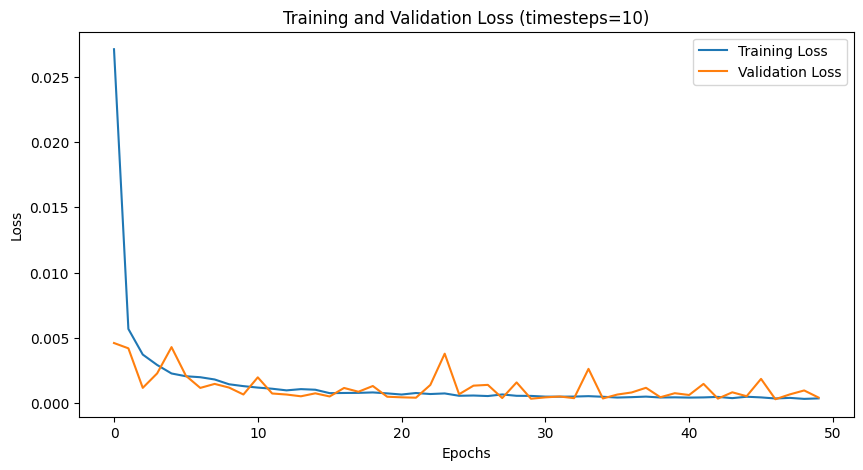

In [15]:
# Plot training and validation loss for each timestep configuration
for timesteps in timesteps_list:
    history = histories[timesteps]
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Training and Validation Loss (timesteps={timesteps})")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Next-Day Prediction and Summary: Generate Next-Day Forecast and Display Metrics
This cell includes the next-day prediction for the latest data, along with a summary of performance metrics (MSE, RMSE, MAE) for each timestep configuration.

In [16]:
# Display next-day predictions for each timestep configuration
print("\nNext-Day Predictions:")
for ts, pred in next_day_predictions.items():
    print(f"Timesteps: {ts} - Next Day Predicted Price: {pred}")



Next-Day Predictions:
Timesteps: 5 - Next Day Predicted Price: 224.4986114501953
Timesteps: 10 - Next Day Predicted Price: 227.6561279296875


In [17]:
# Display and compare performance metrics for each timestep configuration
print("\nPerformance Comparison:")
for ts, metrics in results.items():
    print(f"\nTimesteps: {ts}")
    print(f"MSE: {metrics['MSE']}")
    print(f"RMSE: {metrics['RMSE']}")
    print(f"MAE: {metrics['MAE']}")



Performance Comparison:

Timesteps: 5
MSE: 27.832037980620612
RMSE: 5.2756078304419685
MAE: 3.1196707744987644

Timesteps: 10
MSE: 36.81259675834581
RMSE: 6.067338523466925
MAE: 4.204426473500777


# Conclusion

In this project, we successfully implemented a stock price prediction model using a two-layer Recurrent Neural Network (RNN). By experimenting with different timesteps (5 and 10 days), we were able to analyze how the model performs with varying historical window sizes.

## Key Takeaways
- **Data Preprocessing**: Scaling and creating sequences were crucial steps in preparing the stock data for time series forecasting.
- **Model Architecture**: The two-layer RNN with dropout layers effectively captured sequential patterns in the stock prices, helping to predict future prices.
- **Performance Evaluation**: We evaluated the model using MSE, RMSE, and MAE, observing that different timesteps affect accuracy and error.
- **Next-Day Prediction**: The model provided a next-day prediction based on the most recent data, showcasing its ability to make real-time forecasts.